<a href="https://colab.research.google.com/github/anirudh12032008/kidGPT/blob/main/kidGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dataset

In [10]:
import pandas as pd
import re
from collections import Counter
from torch.utils.data import Dataset

splits = {
    'train': 'data/train-00000-of-00001-aea567a5783be827.parquet',
    'valid': 'data/valid-00000-of-00001-0177e6dbdee45eef.parquet',
    'test': 'data/test-00000-of-00001-0b94257b623049e5.parquet'
}
df_train = pd.read_parquet("hf://datasets/deven367/babylm-10M-children-stories/" + splits["train"])
df_valid = pd.read_parquet("hf://datasets/deven367/babylm-10M-children-stories/" + splits["valid"])
df_test = pd.read_parquet("hf://datasets/deven367/babylm-10M-children-stories/" + splits["test"])

print(df_train.head())

                                                text
0  “If others have tried it,” said Brother Lustig...
1  “Leave it alone,” said the host, “it will cost...
2  Brother Lustig said, “Well, dance as long as y...
3  and got the leg of a chair and struck out into...
4  replied Brother Lustig, “I am used to wanderin...


## Vocabulary

In [11]:
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

counter = Counter()
for text in df_train["text"]:
    counter.update(tokenize(text))

vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(), start=1)}
vocab['<PAD>'] = 0
inverse_vocab = {idx: word for word, idx in vocab.items()}


def text_to_indices(text, vocab):
    tokens = tokenize(text)
    return [vocab[token] for token in tokens if token in vocab]

df_train["input_ids"] = df_train["text"].apply(lambda x: text_to_indices(x, vocab))
df_valid["input_ids"] = df_valid["text"].apply(lambda x: text_to_indices(x, vocab))

df_train.head()

,text,input_ids
0,"“If others have tried it,” said Brother Lustig...","[41, 363, 32, 391, 9, 14, 262, 1713, 12, 42, 4..."
1,"“Leave it alone,” said the host, “it will cost...","[305, 9, 368, 14, 1, 1464, 9, 42, 1714, 18, 97..."
2,"Brother Lustig said, “Well, dance as long as y...","[262, 1713, 14, 79, 1152, 23, 96, 23, 18, 101,..."
3,and got the leg of a chair and struck out into...,"[2, 92, 1, 976, 6, 5, 2103, 2, 626, 38, 58, 1,..."
4,"replied Brother Lustig, “I am used to wanderin...","[379, 262, 1713, 12, 140, 426, 3, 2545, 75, 12..."


## Dataset creation

In [12]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, dataframe, max_length=128):
        self.data = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = self.data.iloc[idx]["input_ids"]
        if len(input_ids) > self.max_length:
            input_ids = input_ids[:self.max_length]
        else:
            input_ids = input_ids + [vocab['<PAD>']] * (self.max_length - len(input_ids))

        return torch.tensor(input_ids)

train_dataset = TextDataset(df_train, max_length=128)
valid_dataset = TextDataset(df_valid, max_length=128)


# Model Designing

In [13]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention_output, _ = self.attention(query, key, value, attn_mask=mask)
        x = self.dropout(self.norm1(attention_output + query))
        forward_output = self.feed_forward(x)
        out = self.dropout(self.norm2(forward_output + x))
        return out


## Language Model


In [14]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length):
        super(LanguageModel, self).__init__()
        self.device = device
        self.embed_size = embed_size

        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_len=max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion
                )
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        out = self.word_embedding(x)
        out = self.position_embedding(out)
        for layer in self.layers:
            out = layer(out, out, out, mask)
        out = self.fc_out(out)
        return out
def generate_text(model, vocab, inverse_vocab, prompt, max_length=50, device='cpu'):
    model.eval()
    input_ids = [vocab.get(token, vocab['<PAD>']) for token in tokenize(prompt)]
    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)

    generated = input_tensor
    for _ in range(max_length):
        with torch.no_grad():
            outputs = model(generated, mask=None)
            next_token_logits = outputs[:, -1, :]
            next_token_probs = F.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(next_token_probs, num_samples=1).item()
            generated = torch.cat((generated, torch.tensor([[next_token_id]]).to(device)), dim=1)

            if next_token_id == vocab['<PAD>']:
                break

    generated_text = [inverse_vocab.get(idx, '<UNK>') for idx in generated.squeeze().tolist()]
    return ' '.join(generated_text)

# Training

In [15]:
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)
embed_size = 256
num_layers = 4
heads = 8
forward_expansion = 4
dropout = 0.1
max_length = 128

model = LanguageModel(
    vocab_size=vocab_size,
    embed_size=embed_size,
    num_layers=num_layers,
    heads=heads,
    device=device,
    forward_expansion=forward_expansion,
    dropout=dropout,
    max_length=max_length
).to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16)

for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch.to(device)

        output = model(input_ids[:, :-1], mask=None)
        loss = loss_fn(output.view(-1, vocab_size), input_ids[:, 1:].reshape(-1))

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


Epoch 1, Loss: 2.5931063159926686
Epoch 2, Loss: 2.2390694186548004
Epoch 3, Loss: 2.1429949145463185
Epoch 4, Loss: 2.0878768762506152
Epoch 5, Loss: 2.0500765534164516
Epoch 6, Loss: 2.0163985032557115
Epoch 7, Loss: 1.9886682143118388
Epoch 8, Loss: 1.964789575687026
Epoch 9, Loss: 1.943116975029863
Epoch 10, Loss: 1.9238891179847186
Epoch 11, Loss: 1.905692344920549
Epoch 12, Loss: 1.8898489495173802
Epoch 13, Loss: 1.874573571602282
Epoch 14, Loss: 1.8615689976633758
Epoch 15, Loss: 1.849820270179706
Epoch 16, Loss: 1.8363473541557291
Epoch 17, Loss: 1.8266821236331483
Epoch 18, Loss: 1.81621294416757
Epoch 19, Loss: 1.8076829041943245
Epoch 20, Loss: 1.798010058721792


# Time for Graphs

Epoch 1, Loss: 1.7912
Epoch 2, Loss: 1.7829
Epoch 3, Loss: 1.7757
Epoch 4, Loss: 1.7699
Epoch 5, Loss: 1.7629


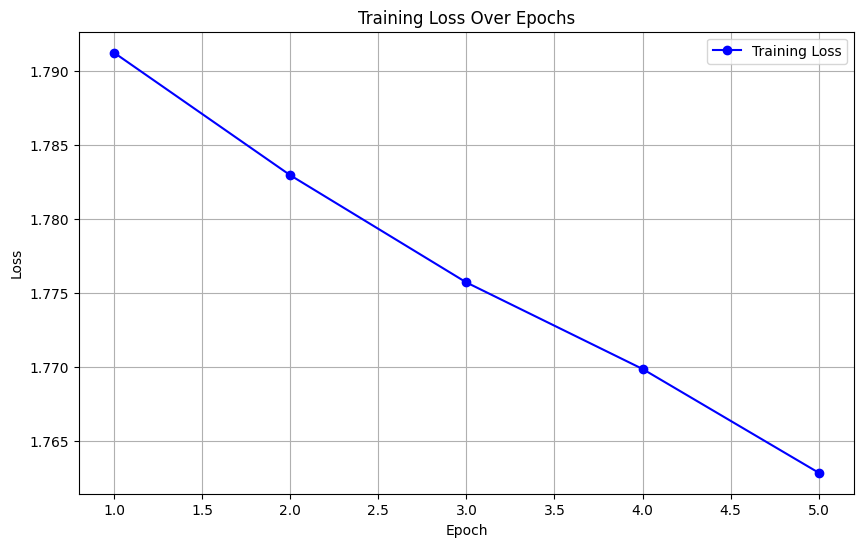

In [16]:
import matplotlib.pyplot as plt

train_losses = []

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch.to(device)

        output = model(input_ids[:, :-1], mask=None)
        loss = loss_fn(output.view(-1, vocab_size), input_ids[:, 1:].reshape(-1))

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#Testing

In [17]:
while True:
  prompt = input("Prompt")
  if prompt == "q":
    break
  generated_text = generate_text(model, vocab, inverse_vocab, prompt, max_length=50, device=device)
  print("Generated text: ", generated_text)


Promptq


#Saving

In [18]:
torch.save(model.state_dict(), "kidGPT.pth")